# Kramer's model validation

The goal of this notebook is to provide a base validation of Kramer's model implementation.

Cases are run as provided in Tab. 3 and final example of Kramer (1952) to check the proper functioning of model.

In [1]:
from kramer_model import KramerModel
from kramer_model import simulate_case
from majordome.utilities.capturing import Capturing
from scipy.integrate import trapz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Last paper example

Before the more exhaustive testing we verify last example provided by Kramer (1952).

Here the value of `n` was changed to 0.049, a round-off from the reported 0.050 seems reasonable here.

In [2]:
alpha = np.arctan(0.042) * 180 / np.pi

rho = 1480.0
beta = 45.0

D = 1.9
L = 13.7

n = 0.049
vdot = 2.88e-03
mdot = rho * vdot

Nphi_x_Nk = 1.35

eqn = KramerModel(alpha, beta, D, L, rho)
ratio = eqn.prod_dimensionles(mdot, n) / Nphi_x_Nk
ratio

0.9980821418103184

## Base data

In the next cell we provide the kiln dimensions used by Kramer (1952) to experimentally validate the model. Data from their Tab. 3 is then loaded and can be inspected below.

In [3]:
D = 0.197
L = 1.78
V = np.pi * (D / 2)**2 * L

table3 = pd.read_csv("table03.csv")
table3

,rho,beta,tan_alpha,n,mdot,prod_dimless,xr_calc,hold_real
0,1480.0,36.0,0.0094,0.059,0.00515,18.30,0.111,8.10
1,1480.0,36.0,0.0094,0.090,0.00268,6.25,0.054,5.00
2,1480.0,36.0,0.0094,0.195,0.01320,14.20,0.088,7.75
3,1480.0,36.0,0.0094,0.232,0.00724,6.55,0.043,3.85
4,1480.0,36.0,0.0100,0.040,0.00638,29.70,0.169,13.30
5,1480.0,36.0,0.0100,0.040,0.00500,23.20,0.144,11.20
6,1480.0,36.0,0.0100,0.069,0.00920,24.80,0.150,10.60
7,1480.0,36.0,0.0100,0.069,0.00653,17.60,0.113,8.50
8,1480.0,36.0,0.0100,0.106,0.01500,27.80,0.162,12.20
9,1480.0,36.0,0.0100,0.159,0.01200,14.00,0.092,7.49


A new table is created for providing comparison of the above and newly computed values.

In [4]:
df = pd.DataFrame(columns=[
    "prod_calc",
    "prod_real",
    "xr_calc",
    "xr_real",
    "xr_appr",
    "hold_calc",
    "hold_real"
])

For each row of Tab. 3 from Kramer (1952) we use the model implementation to fill the above.

In [5]:
for k, row in table3.iterrows():
    pars = row.to_numpy()
    rho, beta, tan_a, n, phim, prod_real, Xr_real, hold_real = pars

    alpha = np.arctan(tan_a) * 180.0 / np.pi
    
    eqn = KramerModel(alpha, beta, D, L, rho)
    z, h, _, Xr_calc = eqn.simulate(0.0, n, phim, n_points=50)
    prod_calc = eqn.prod_dimensionles(phim, n)

    Xr_appr = 0.5 * (2 * h / D)**(4/3)
    Xr_appr = trapz(Xr_appr, z) / L

    hold_calc = Xr_calc * V * rho
    
    df.loc[k] = [
        prod_calc,
        prod_real,
        Xr_calc,
        Xr_real,
        Xr_appr,
        hold_calc,
        hold_real
    ]

Below we compute the relative errors for the output parameters.

Although in some cases an important error (yet to be explained) is found, the model is in general reproduced.

In [6]:
df["err_prod"] =    100 * (df["prod_calc"] - df["prod_real"]) / df["prod_real"]
df["err_xr_calc"] = 100 * (df["xr_calc"]   - df["xr_real"])   / df["xr_real"]
df["err_xr_appr"] = 100 * (df["xr_appr"]   - df["xr_real"])   / df["xr_real"]
df["err_hold"] =    100 * (df["hold_calc"] - df["hold_real"]) / df["hold_real"]

pd.options.display.float_format = "{:.3f}".format
df

,prod_calc,prod_real,xr_calc,xr_real,xr_appr,hold_calc,hold_real,err_prod,err_xr_calc,err_xr_appr,err_hold
0,18.379,18.300,0.108,0.111,0.113,8.660,8.100,0.432,-2.839,2.181,6.914
1,6.270,6.250,0.047,0.054,0.053,3.744,5.000,0.318,-13.660,-2.465,-25.124
2,14.253,14.200,0.089,0.088,0.095,7.130,7.750,0.373,0.904,7.731,-7.998
3,6.571,6.550,0.048,0.043,0.054,3.887,3.850,0.317,12.585,26.737,0.970
4,29.674,29.700,0.168,0.169,0.172,13.487,13.300,-0.086,-0.615,1.514,1.405
5,23.256,23.200,0.139,0.144,0.144,11.201,11.200,0.241,-3.134,0.060,0.005
6,24.806,24.800,0.147,0.150,0.151,11.766,10.600,0.025,-2.318,0.586,10.995
7,17.607,17.600,0.113,0.113,0.118,9.054,8.500,0.040,-0.221,4.597,6.513
8,26.327,27.800,0.153,0.162,0.157,12.311,12.200,-5.297,-5.357,-2.815,0.913
9,14.041,14.000,0.095,0.092,0.101,7.606,7.490,0.295,2.959,9.369,1.549


## Dimensionless profiles

Using a simplified analytical approach, Kramer (1952) provide in Fig. 3 of the paper a dimensionless comparison of bed height across a certain range of dimensionless outlet heights. The following provides a reproduction of their computations.

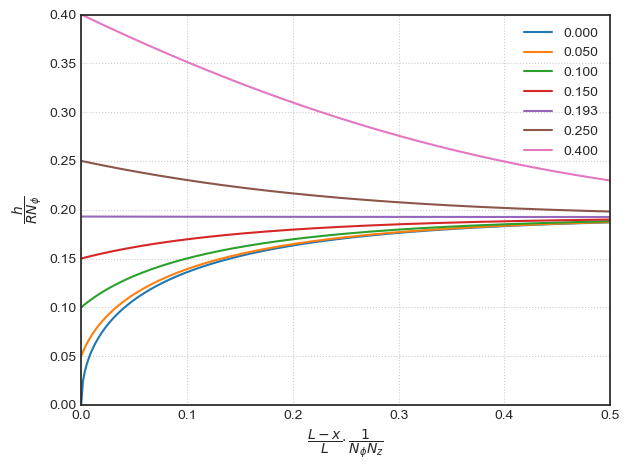

In [7]:
# Kiln characteristics.
L = 1.78
D = 0.197
alpha = np.rad2deg(np.arctan(0.0094))

# Material characteristics.
rho = 1480
beta = 36.0

# Process parameters.
n = 0.059
phim = 5.15e-03

# Create model under given parameters.
eqn = KramerModel(alpha, beta, D, L, rho)

# Dimensionless values to compute curves.
hvals = [0, 0.05, 0.10, 0.15, 0.193, 0.25, 0.40]

# Space discretization (in dimensionless space).
x_max = 0.5

plt.close("all")
plt.style.use("seaborn-white")

for ht in hvals:
    with Capturing() as _:
        # Provide value with dimensions to solver.
        ht = ht * (D / 2) * eqn.n_phi(phim, n)
        z, h, _, _ = eqn.analytical(ht, n, phim, x_max=x_max)

    # Make value dimensionless again to plot.
    h = (h / (D / 2 * eqn.n_phi(phim, n)))[::-1]

    plt.plot(z, h, label=f"{h[0]:.3f}")
    plt.grid(linestyle=":")
    plt.xlabel(r"$\dfrac{L-x}{L}\cdotp\dfrac{1}{N_{\phi}N_{z}}$")
    plt.ylabel(r"$\dfrac{h}{RN_{\phi}}$")
    plt.legend(loc=1)
    plt.xlim(0, 0.5)
    plt.ylim(0, 0.4)

plt.tight_layout()
plt.show()

## Comparison of analytical and numerical

Since we have implemented the general differential equation without the simplifications introduced by Kramer (1952) to reach an analytical solution, it is important to provide a means of comparison from the numerical and analytical approach.

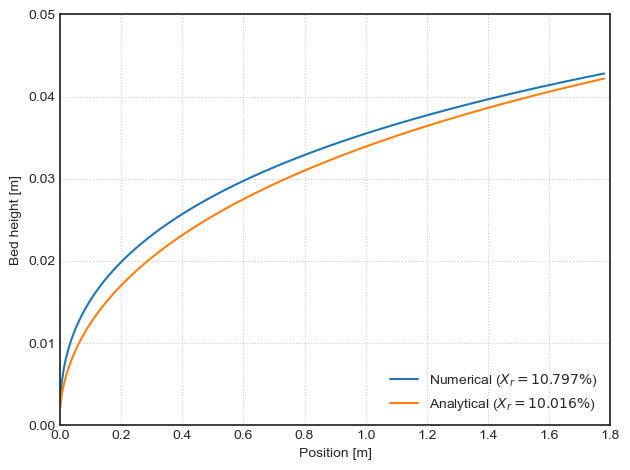

In [8]:
nz = 1000
hl = 0.02 * (D / 2)

with Capturing() as _:
    simulate_case(L, D, alpha, beta, rho, n, phim, hl,
                  n_points=1000, xlim=(0.0, 1.8), ylim=(0.0, 0.05))

## Use with known conditions

Finally we employ the equation to a known industrial case.

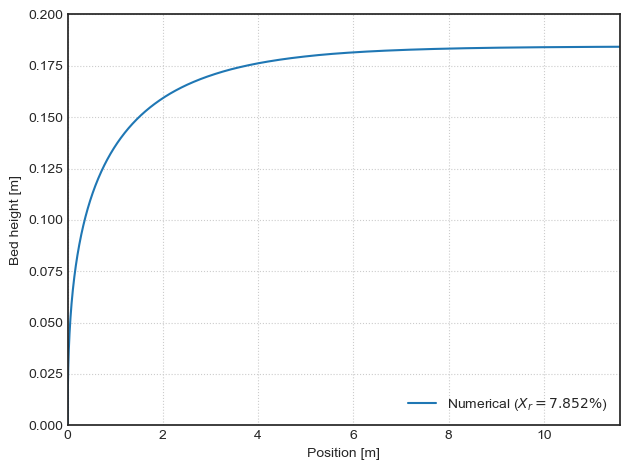

In [9]:
crust = 3 * 0.0254

L = 11.6
D = 1.37 - crust
alpha = 2.98

beta = 45.0
rho = 150.0

n = 1.2 / 60
phim = 7400 / (24 * 3600)
hl = 0.001

with Capturing() as out:
    simulate_case(L, D, alpha, beta, rho, n, phim, hl, n_points=3000,
                  xlim=(0.0, L), ylim=(0.0, 0.2), analytical=False)

## 